targets.shape=(10000, 2)


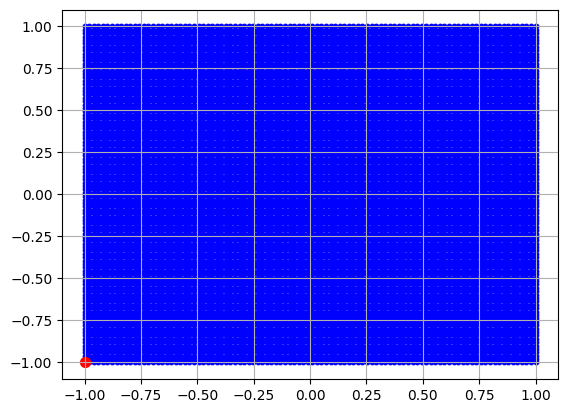

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from pprint import pp
import numpy as np
import time


# Chose number of robots
k = int(6)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(100)
# Choose the redundancy parameter (have each target be visited by exactly that many robots)
rp = min(3, k)

# Fuel Capacity Parameters
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = (max_fuel_cost_to_node * 2) * 1.5  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = list(range(len(targets)))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
# depots = np.concatenate((depots, depots))
depot_indices = list(range(len(targets), len(targets)+len(depots)))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = list(range(len(targets)+len(depots)))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
from tqdm import tqdm


start = time.time()
# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i in tqdm(node_indices):
    for j in node_indices[i:]:
        cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
        cost[j,i] = cost[i,j]
        # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")

print(f"took {time.time() - start} seconds")


100%|██████████| 10001/10001 [00:45<00:00, 221.57it/s]

took 45.14348793029785 seconds


In [3]:
from utils.visualize import visualize_paths, visualize_subtours


# Initialize a very inefficient list of subtours
def worst_case_solution():
    all_subtours = np.array([[depot_indices[0], target_indices[target_i], depot_indices[0]] for target_i in target_indices])
    # all_subtours = [[depot_indices[0], target_indices[0], depot_indices[0]],
    #                 [depot_indices[0], target_indices[1], depot_indices[0]],
    #                     ...
    #                 ]
    print(f"{all_subtours.shape=}")
    
    # Assign all subtours to the first robot for now.
    robot_subtours = [ [] for _ in range(k) ]
    robot_subtours[0].extend(all_subtours)
    return robot_subtours

# robot_subtours = worst_case_solution()
# visualize_paths(robot_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")

In [4]:
# Initialize a slightly more efficient list of subtours
from utils.visualize import visualize_paths, visualize_subtours
import heapq


def second_worst_case_solution():
    all_subtours = []
    
    collinear_targets = {}
    for target_i in target_indices:
        v1 = nodes[target_i]
        v2 = nodes[depot_indices[0]]
        angle = np.arctan2(*(v1 - v2)) % (2 * np.pi)
        dist = float(np.linalg.norm(nodes[target_i]-nodes[depot_indices[0]]))
        
        is_target_on_collinear_targets = False
        for target_angle in collinear_targets.keys():
            if np.isclose(target_angle, angle):
                is_target_on_collinear_targets = True
                heapq.heappush(collinear_targets[target_angle], (dist, target_i))
                # print(f"\tAdding to {angle=}: {collinear_targets[target_angle]=}")
                break
        if not is_target_on_collinear_targets:
            collinear_targets[angle] = []
            heapq.heappush(collinear_targets[angle], (dist, target_i))
            # print(f"\tCreating a new one at {angle=}: {collinear_targets[angle]=}")
    
    # pp(collinear_targets)
    for _, target_queue in collinear_targets.items():
        new_subtour = [depot_indices[0]]
        while target_queue:
            _, target_i = heapq.heappop(target_queue)
            new_subtour.append(target_i)
        new_subtour.append(depot_indices[0])
        all_subtours.append(new_subtour)
    # pp(all_subtours)
    
    # Assign all subtours to the first robot for now.
    robot_subtours = [ [] for _ in range(k) ]
    robot_subtours[0].extend(all_subtours)
    
    return robot_subtours


# robot_subtours = second_worst_case_solution()
# visualize_paths(robot_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")

In [5]:
from utils.visualize import visualize_paths, visualize_subtours


def second_worst_case_distributed_solution():
    all_subtours = second_worst_case_solution()[0]

    all_subtours_cost = []
    for subtour in all_subtours:
        subtour_cost = 0
        curr_node = subtour[0]
        for next_node in subtour[1:]:
            subtour_cost += np.sqrt((nodes[curr_node,0]-nodes[next_node,0]) ** 2 + (nodes[curr_node,1]-nodes[next_node,1]) ** 2)
            curr_node = next_node
        all_subtours_cost.append(subtour_cost)
    # pp(all_subtours_cost)
    all_subtours_cost = np.array(all_subtours_cost)
    # print(f"{all_subtours_cost=}")
    
    all_subtours_cost_sorted_indices = all_subtours_cost.argsort()
    # print(f"{all_subtours_cost_sorted_indices=}")
    
    # print(f"{all_subtours_cost[all_subtours_cost_sorted_indices]=}")
    
    
    # https://takeuforward.org/arrays/split-array-largest-sum/
    def countPartitions(a, maxSum):
        # n = len(a)  # size of array
        partitions = 1
        subarraySum = 0
        partitions_array = [[]]
        # partitions_max_array = []
        for i in all_subtours_cost_sorted_indices:
            if subarraySum + a[i] <= maxSum:
                # insert element to current subarray
                subarraySum += a[i]
            else:
                # partitions_max_array.append(subarraySum)
                # insert element to next subarray
                partitions += 1
                subarraySum = a[i]
                partitions_array.append([])
            partitions_array[partitions-1].append(i)
    
        return partitions, partitions_array  #, partitions_max_array
    
    def largestSubarraySumMinimized(a, k):
        low = max(a)
        high = sum(a)
    
        for maxSum in np.linspace(low, high, num=int(np.ceil((high - low)/0.01))):
        # for maxSum in range(low, high+1):
            p, p_a = countPartitions(a, maxSum)
            if p == k:
                return p_a
        return None
    
    distributed_subtours_indices = largestSubarraySumMinimized(all_subtours_cost, k)
    # print(f"{distributed_subtours_indices=}")
    
    distributed_subtours = []
    for distributed_subtours_i in distributed_subtours_indices:
        robot_subtours = []
        for subtour_i in distributed_subtours_i:
            robot_subtours.append(all_subtours[subtour_i])
        distributed_subtours.append(robot_subtours)
    
    # pp(distributed_subtours)
    return distributed_subtours


# distributed_subtours = second_worst_case_distributed_solution()
# visualize_paths(distributed_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")

In [6]:
# Still use the subtour cost to assign, but use an ordering based on angle/heading to prefer directionality
from utils.visualize import visualize_paths, visualize_subtours


def second_worst_case_positionally_distributed_solution():
    all_subtours = second_worst_case_solution()[0]
    angle_values = []
    all_subtours_cost = []
    for subtour in all_subtours:
        v1 = nodes[subtour[1]]
        v2 = nodes[depot_indices[0]]
        angle = np.arctan2(*(v1 - v2)) % (2 * np.pi)
        angle_values.append(angle)
        
        subtour_cost = 0
        curr_node = subtour[0]
        for next_node in subtour[1:]:
            subtour_cost += np.sqrt((nodes[curr_node,0]-nodes[next_node,0]) ** 2 + (nodes[curr_node,1]-nodes[next_node,1]) ** 2)
            curr_node = next_node
        all_subtours_cost.append(subtour_cost)
    
    angle_values = np.array(angle_values)
    all_subtours_cost = np.array(all_subtours_cost)
    
    angle_sorted_indices = angle_values.argsort()
    
    
    # https://takeuforward.org/arrays/split-array-largest-sum/
    def countPartitions(a, maxSum):
        # n = len(a)  # size of array
        partitions = 1
        subarraySum = 0
        partitions_array = [[]]
        # partitions_max_array = []
        for i in angle_sorted_indices:
            if subarraySum + a[i] <= maxSum:
                # insert element to current subarray
                subarraySum += a[i]
            else:
                # partitions_max_array.append(subarraySum)
                # insert element to next subarray
                partitions += 1
                subarraySum = a[i]
                partitions_array.append([])
            partitions_array[partitions-1].append(i)
    
        return partitions, partitions_array  #, partitions_max_array
    
    def largestSubarraySumMinimized(a, k):
        low = max(a)
        high = sum(a)
    
        for maxSum in np.linspace(low, high, num=int(np.ceil((high - low)/0.01))):
        # for maxSum in range(low, high+1):
            p, p_a = countPartitions(a, maxSum)
            if p == k:
                return p_a
        return None
    
    distributed_subtours_indices = largestSubarraySumMinimized(all_subtours_cost, k)
    # print(f"{distributed_subtours_indices=}")
    
    distributed_subtours = []
    for distributed_subtours_i in distributed_subtours_indices:
        robot_subtours = []
        for subtour_i in distributed_subtours_i:
            robot_subtours.append(all_subtours[subtour_i])
        distributed_subtours.append(robot_subtours)
    
    # pp(distributed_subtours)
    return distributed_subtours


# distributed_subtours = second_worst_case_positionally_distributed_solution()
# visualize_paths(distributed_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")

In [7]:
# Still use the subtour cost to assign, but use an ordering based on angle/heading to prefer directionality
from utils.visualize import visualize_paths, visualize_subtours
from utils.tsp_solver import k_opt


def positionally_distributed_tsp_solution():
    distributed_subtours = second_worst_case_positionally_distributed_solution()

    optimized_subtours = []
    for ki in range(len(distributed_subtours)):
        subtour_nodes = set()
        for subtour in distributed_subtours[ki]:
            subtour_nodes = subtour_nodes.union(set(subtour))
        subtour_nodes = list(subtour_nodes)
        
        subtour, subtour_dist = k_opt(subtour_nodes, cost, 2)
        optimized_subtours.append([subtour])
    
    return optimized_subtours


# optimized_subtours = positionally_distributed_tsp_solution()
# visualize_paths(optimized_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")

Step 1 took 0.01198577880859375 seconds.
Step 2: Found 33 subtours.
Step 2 took 5.893503904342651 seconds.
	[subtour 1/33] took 28.119 seconds and improved 0.791%.
	[subtour 2/33] took 81.491 seconds and improved 4.756%.
	[subtour 3/33] took 97.905 seconds and improved 6.667%.
	[subtour 10/33] took 104.963 seconds and improved 9.504%.
	[subtour 7/33] took 107.726 seconds and improved 9.003%.
	[subtour 6/33] took 110.424 seconds and improved 11.062%.
	[subtour 13/33] took 113.663 seconds and improved 10.154%.
	[subtour 4/33] took 121.092 seconds and improved 9.436%.
	[subtour 14/33] took 121.638 seconds and improved 9.285%.
	[subtour 5/33] took 131.120 seconds and improved 10.727%.
	[subtour 11/33] took 131.222 seconds and improved 11.501%.
	[subtour 8/33] took 133.304 seconds and improved 10.540%.
	[subtour 12/33] took 133.448 seconds and improved 11.092%.
	[subtour 15/33] took 135.552 seconds and improved 4.751%.
	[subtour 16/33] took 139.470 seconds and improved 2.690%.
	[subtour 18/

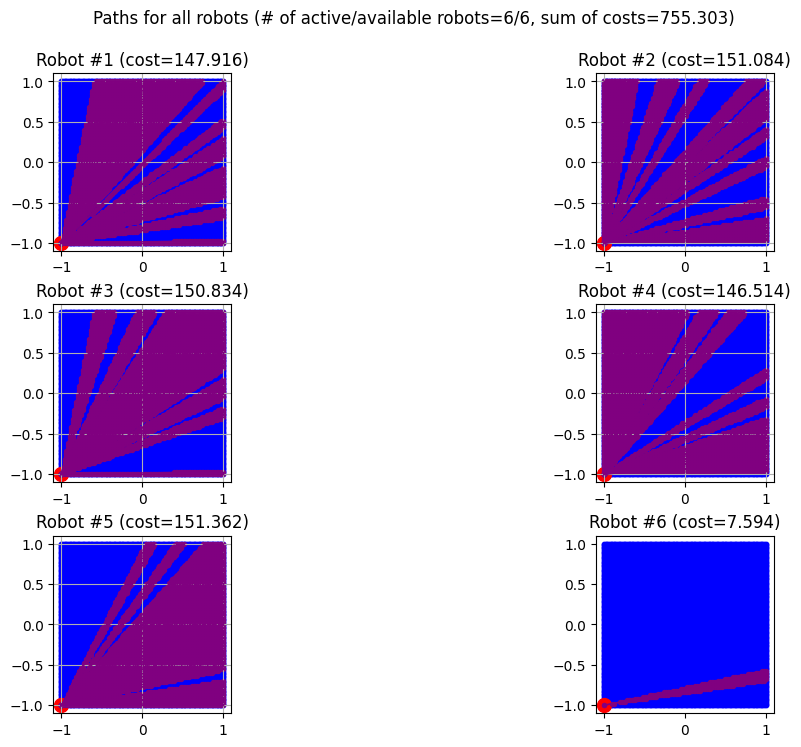

In [8]:
from utils.tsp_solver import k_opt
from utils.visualize import visualize_paths, visualize_subtours
from concurrent.futures import ProcessPoolExecutor
import time
import os


def divideArrayByP(array, maxp, countf, low=None, high=None):
    if low is None:
        low = min(array)
    if high is None: 
        high = sum(array)

    # condition = True
    maxSum = low
    p_prev = len(array)
    p_prev_same_count = 0
    maxSum_max = high
    while True:
        delta = maxSum_max - maxSum
        # print(f"{maxSum_max=} {delta=} {maxSum=}")
        p, p_a, p_c = countf(array, maxSum)
        # print(f"{p=} {p_prev=} {maxSum=}")
        # print(f"{p=} {p_a=} {p_c=}")
        if p == p_prev:
            p_prev_same_count += 1
        else:
            p_prev_same_count = 0
        
        if p == maxp or p_prev_same_count > 3:
            return p_a, p_c, maxSum

        if p > maxp and maxSum <= high:
            maxSum = maxSum + delta / 2.
            # maxSum_min = maxSum
        elif p > maxp and maxSum == high:
            return p_a, maxSum
        else:
            maxSum = maxSum - delta / 2.
            # maxSum_max = maxSum

        p_prev = p


def positionally_distributed_tsp_w_fuel_constraint_solution():
    # Step 1: sort the node indices for creating subtours
    start = time.time()
    heading_values = []
    for n_i in target_indices:
        v1 = nodes[n_i]
        v2 = nodes[depot_indices[0]]
        heading = np.arctan2(*(v1 - v2)) % (2 * np.pi)
        heading_values.append(heading)
        # nodes_cost.append(cost[n_i, depot_indices[0]])
    
    heading_values = np.array(heading_values)
    # print(f"{heading_values.shape=}")
    
    nodes_costs = cost[:depot_indices[0], depot_indices[0]]
    # print(f"{nodes_costs.shape=}")

    sorted_indices = np.lexsort((nodes_costs, heading_values))
    # for i, ti in enumerate(sorted_indices):
    #     print(f"{i=} {ti=} {heading_values[ti]=} {nodes_costs[ti]=}")
    
    print(f"Step 1 took {time.time() - start} seconds.")
    start = time.time()
    
    
    # Step 2: Divide nodes to subtours s.t. cost <= L
    # https://takeuforward.org/arrays/split-array-largest-sum/
    def countSubtourPartitions(a, maxSum):            
        # n = len(a)  # size of array
        partitions = 1
        partitions_array = [[depot_indices[0], depot_indices[0]]]
        partitions_cost = []
        node_addition_cost = 0
        subarraySum = 0
        for i in sorted_indices:
            node_addition_index = 1
            node_addition_cost = np.inf
            subarraySum = 0
            for j, n_j in enumerate(partitions_array[partitions-1][:-1]):
                n_k = partitions_array[partitions-1][j+1]
                edge_cost = cost[n_j, n_k]
                subarraySum += edge_cost
                new_edge_cost = cost[n_j, i] + cost[i, n_k]
                if new_edge_cost - edge_cost < node_addition_cost:
                    node_addition_cost = new_edge_cost - edge_cost
                    node_addition_index = j + 1
            
            if subarraySum + node_addition_cost >= maxSum:
                # if not, insert element to next subarray
                partitions_cost.append(subarraySum)
                partitions += 1
                node_addition_index = 1
                partitions_array.append([depot_indices[0], depot_indices[0]])
            partitions_array[partitions-1].insert(node_addition_index, i)
            # print(f"{partitions_array[partitions-1]}")
        
        if len(partitions_array) != len(partitions_cost):
            partitions_cost.append(subarraySum+node_addition_cost)
        return partitions, partitions_array, partitions_cost
    
    distributed_nodes_indices, tsp_upper_bound, maxSum = divideArrayByP(nodes_costs, k, countSubtourPartitions, low=2 * np.sqrt(8), high=L)
    print(f"Step 2: Found {len(distributed_nodes_indices)} subtours.")
    # print(f"{L=}")
    # print(f"{len(distributed_nodes_indices)=} {maxSum=}")
    # print(f"{distributed_nodes_indices=}")
    # print(f"{tsp_upper_bound=}")
    
    # visualize_subtours(distributed_nodes_indices, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")

    print(f"Step 2 took {time.time() - start} seconds.")
    start = time.time()
    
    # Step 3: Further optimize the subtours by running tsp on them
    tsp_subtours = []
    tsp_costs = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()-1) as executor:
        futures = []
        for heur_subtour in distributed_nodes_indices:
            futures.append(executor.submit(k_opt, *[heur_subtour, cost, 2]))

        uncompleted_jobs = list(range(len(futures)))
        while len(uncompleted_jobs) != 0:
            new_uncompleted_jobs = uncompleted_jobs
            for future_i in uncompleted_jobs:
                if futures[future_i].done():
                    best_subtour, c = futures[future_i].result()
                    print(f"\t[subtour {future_i+1}/{len(futures)}] took {time.time() - start:.3f} seconds and improved {(1-c/tsp_upper_bound[future_i])*100:.3f}%.")
                    tsp_subtours.append(best_subtour)
                    tsp_costs.append(c)
                    new_uncompleted_jobs.remove(future_i)
                else:
                    time.sleep(0.1)
            uncompleted_jobs = new_uncompleted_jobs
            

    # visualize_subtours(tsp_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")
    
    tsp_indices = np.array(tsp_costs).argsort().tolist()
    print(f"Step 3 took {time.time() - start} seconds.")
    start = time.time()

    # Step 4: Ensure rp
    num_of_subtours = len(tsp_subtours)
    for i in range(num_of_subtours, num_of_subtours * rp):
        tsp_subtours.append(tsp_subtours[i % num_of_subtours])
        tsp_costs.append(tsp_costs[i % num_of_subtours])
        tsp_indices.append(i)
    
    print(f"Step 4 took {time.time() - start} seconds.")
    start = time.time()
    
    # Step 5: Divide subtours between robots
    def countRobotPartitions(a, maxSum):
        # n = len(a)  # size of array
        partitions = 1
        subarraySum = 0
        partitions_array = [[]]
        partitions_cost = []
        for i in tsp_indices:
            if subarraySum + a[i] <= maxSum:
                # insert element to current subarray
                subarraySum += a[i]
            else:
                # if not, insert element to next subarray
                partitions_cost.append(subarraySum)
                partitions += 1
                subarraySum = a[i]
                partitions_array.append([])
            partitions_array[partitions-1].append(tsp_subtours[i])
    
        return partitions, partitions_array, partitions_cost

    distributed_robot_nodes_indices, _, maxSum = divideArrayByP(tsp_costs, k, countRobotPartitions)

    print(f"Step 5 took {time.time() - start} seconds.")
    
    return distributed_robot_nodes_indices, maxSum

    
    # return None

optimized_subtours, _ = positionally_distributed_tsp_w_fuel_constraint_solution()
for i, optimized_subtour in enumerate(optimized_subtours):
    print(f"[{i}] {len(optimized_subtour)=}")
visualize_paths(optimized_subtours, nodes, node_indices, target_indices, depot_indices, cost, mode="faster")